# Transfer Learning

The learning goals of this tutorial are:

- Illustrate the transfer learning procedure using a model pre-trained on [ImageNet](http://www.image-net.org/).
- Get familiar with the Keras API to load pre-trained models and freeze layers during training.

## Step-by-step Procedure

1. Load dataset, explore it (display images, mean, min, max values, etc.) and split it into train, validation and test sets
2. Data scaling
3. One hot encoding
4. Define your callbacks (save your model, patience, etc.)
5. Set up data Augmentation

6. Transfer Learning
    
    6.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)
    
    6.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model
    
    6.3. Add a top (i.e., the prediction layers)
    
    6.4  Train the model using your dataset
    
    6.5 Unfreeze the layers and fine-tune the whole model (i.e., train your model with a very small learning rate)
    
    6.6 If you are satisfied with the train and validation performance go to the next step
    
    6.7 If you are not satisfied with the train and validation performance go back to step 6.1.

7. Test your model on the test and extract relevant metrics

In [ ]:
! pip install scikit-image

In [1]:
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds # tensorflow datasets - pip install tensorflow-datasets
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import transform # pip install scikit-image

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1. Load dataset, explore it  and split it into train, validation and test sets

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)

class_names = ["roses", "daisy",  "dandelion", "sunflowers", "tulips" ] 
images = np.asarray(glob.glob(data_dir + "/*/*.jpg"))
labels = np.asarray([f.split("/")[-2] for f in images])

print(len(images))
print(images[:4])
print(labels[:4])

3670
['/home/roberto/.keras/datasets/flower_photos/roses/5897035797_e67bf68124_n.jpg'
 '/home/roberto/.keras/datasets/flower_photos/roses/1485142251_ca89254442.jpg'
 '/home/roberto/.keras/datasets/flower_photos/roses/685724528_6cd5cbe203.jpg'
 '/home/roberto/.keras/datasets/flower_photos/roses/534228982_4afbcece9b_m.jpg']
['roses' 'roses' 'roses' 'roses']


In [3]:
# Representing class names as integers 
Y = np.zeros(len(labels))
for ii in range(len(class_names)):
    Y[labels == class_names[ii]] =  ii

In [4]:
# Dimensions we will resize the images
img_height = 180
img_width = 180

X = np.zeros((len(images),img_height,img_width,3))
for (ii,img) in enumerate(images):
    X[ii] = transform.resize(plt.imread(img),(img_height,img_width,3))

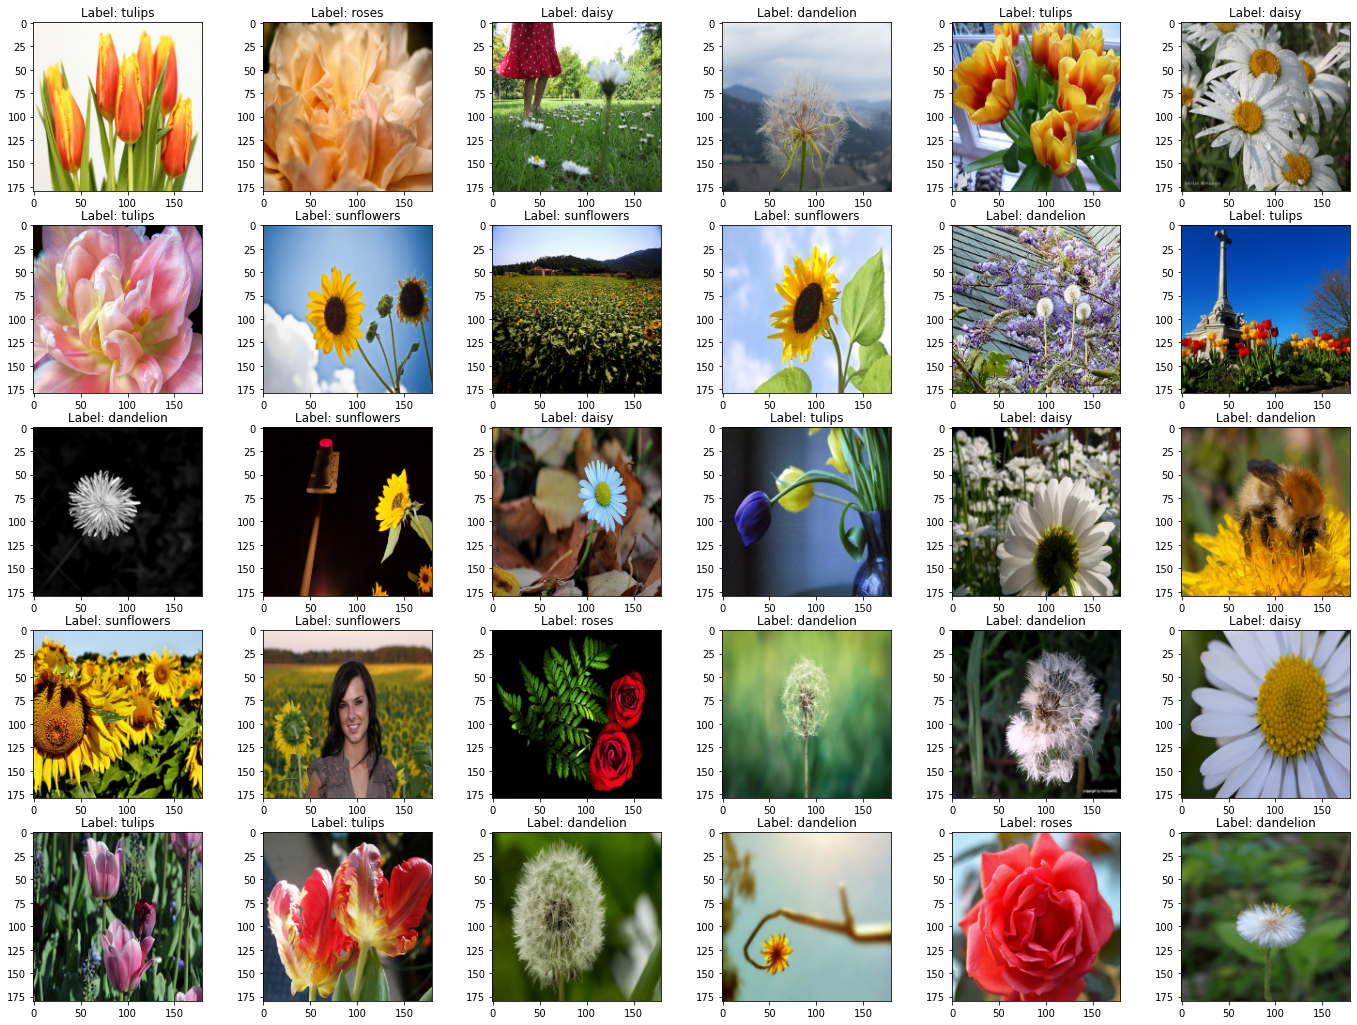

In [5]:
# Displaying some samples from the development set
sample_indexes = np.random.choice(np.arange(X.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X[jj], cmap = "gray")
    plt.title("Label: %s" %class_names[int(Y[jj])])
plt.show()

In [6]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X.shape[0], dtype = int)
np.random.shuffle(indexes)
X = X[indexes]
Y = Y[indexes]

# Train/validation/test split
nsplit1 = int(0.75*X.shape[0]) 
nsplit2 = int(0.9*X.shape[0]) 
# Train and validation split

X_train = X[:nsplit1]
Y_train = Y[:nsplit1]
X_val = X[nsplit1:nsplit2]
Y_val = Y[nsplit1:nsplit2]
X_test = X[nsplit2:]
Y_test = Y[nsplit2:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)


Train set
Images:  (2752, 180, 180, 3)
Labels shape:  (2752,)

Validation set
Images:  (551, 180, 180, 3)
Labels shape:  (551,)
Images:  (367, 180, 180, 3)
Labels shape:  (367,)


In [7]:
# The data seems to be already scale dbetween 0 and 1, so we do nothing
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0.0 1.0 0.3941543294508367 0.2928117695026892
0.0 1.0 0.3993890041286746 0.29421046740848444


## Data scaling

In [8]:
train_mean, train_std = X_train.mean(), X_train.std()
X_train = (X_train - train_mean)/train_std
X_val = (X_val - train_mean)/train_std
X_test = (X_test - train_mean)/train_std

## 3. One hot encoding

In [9]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[2. 3. 4. 1. 0.]

One hot encoded labels:
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


## 4. Define your callbacks (save your model, patience, etc.)

In [10]:
model_name = "vgg_flowers_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 5. Keras Data Augmentation

In [11]:
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size) 

0.0061998507 0.9830802
-1.5957546 2.4097002


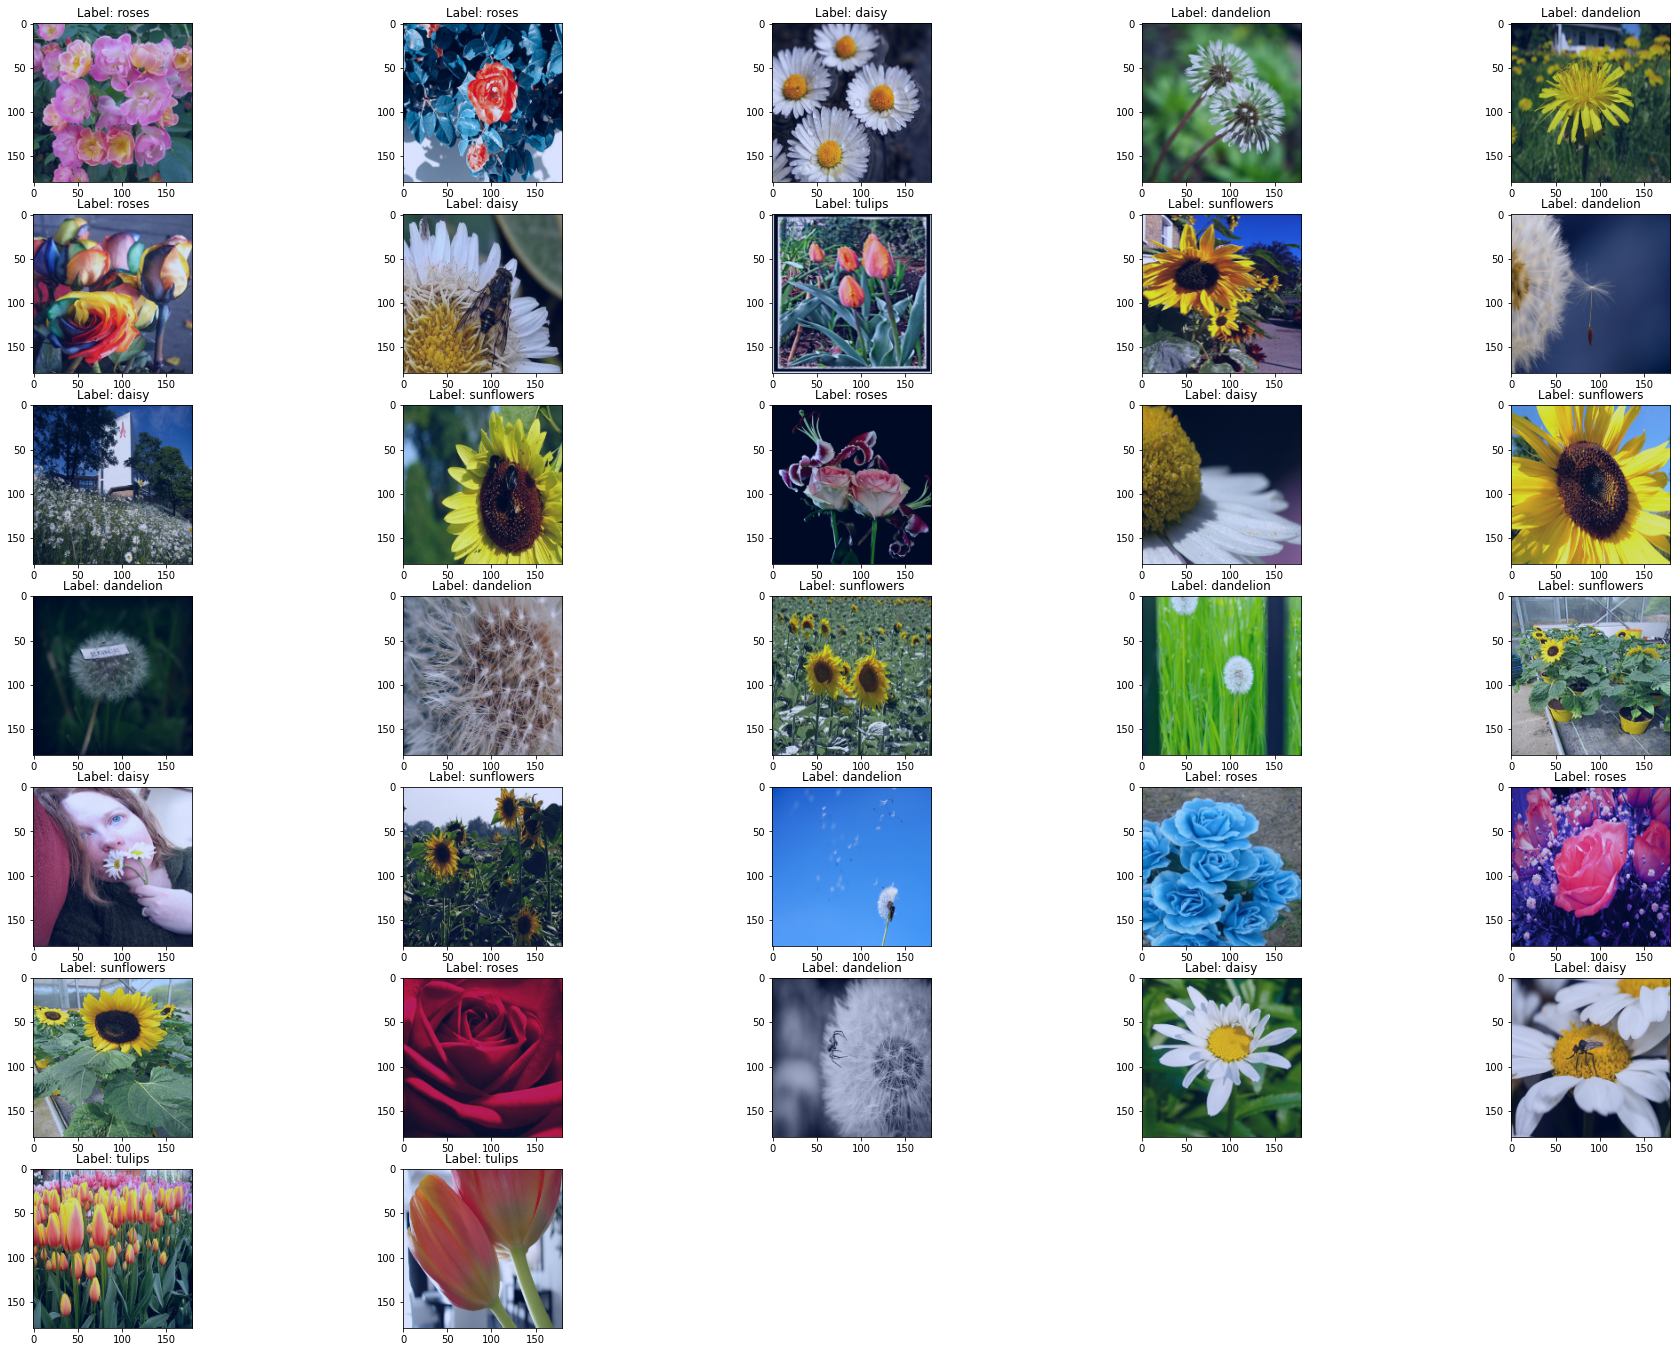

In [12]:
# Disaplying some samples from the development set
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title("Label: %s" %class_names[int(Ybatch[ii].argmax())])
plt.show()

## 6. Transfer Learning

6.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

6.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model

In [14]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

6.3. Add a top (i.e., the prediction layers)

In [15]:
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=False)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = input_image, outputs =out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 64005     
Total params: 14,778,693
Trainable params: 64,005
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_flow,epochs = 8, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/8
86/86 [==============================] - 7s 80ms/step - loss: 1.1535 - accuracy: 0.5807 - val_loss: 0.8591 - val_accuracy: 0.7060 - lr: 1.0000e-04
Epoch 2/8
86/86 [==============================] - 6s 75ms/step - loss: 0.7207 - accuracy: 0.7754 - val_loss: 0.6987 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 3/8
86/86 [==============================] - 6s 75ms/step - loss: 0.5720 - accuracy: 0.8172 - val_loss: 0.6278 - val_accuracy: 0.7768 - lr: 1.0000e-04
Epoch 4/8
86/86 [==============================] - 6s 75ms/step - loss: 0.4850 - accuracy: 0.8590 - val_loss: 0.5882 - val_accuracy: 0.7804 - lr: 1.0000e-04
Epoch 5/8
86/86 [==============================] - 6s 75ms/step - loss: 0.4270 - accuracy: 0.8757 - val_loss: 0.5715 - val_accuracy: 0.8022 - lr: 5.0000e-05
Epoch 6/8
86/86 [==============================] - 6s 75ms/step - loss: 0.3989 - accuracy: 0.8892 - val_loss: 0.5562 - val_accuracy: 0.8040 - lr: 5.0000e-05
Epoch 7/8
86/86 [==============================] - 6s 75ms

In [17]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = True
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(input_image, out)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights(model_name)
model.fit(train_flow,batch_size = 32, epochs = 5, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 64005     
Total params: 14,778,693
Trainable params: 14,778,693
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
86/86 [==============================] - 16s 189ms/step - loss: 0.2747 - accuracy: 0.9190 - val_loss: 0.4771 - val_accuracy: 0.8258 - lr: 1.0000e-06
Epoch 2/5
86/86 [==============================] - 17s 193ms/step - loss: 0.2165 

In [18]:
model.load_weights(model_name)
metrics = model.evaluate(X_test,Y_test_oh)

12/12 [==============================] - 1s 110ms/step - loss: 0.3561 - accuracy: 0.8828


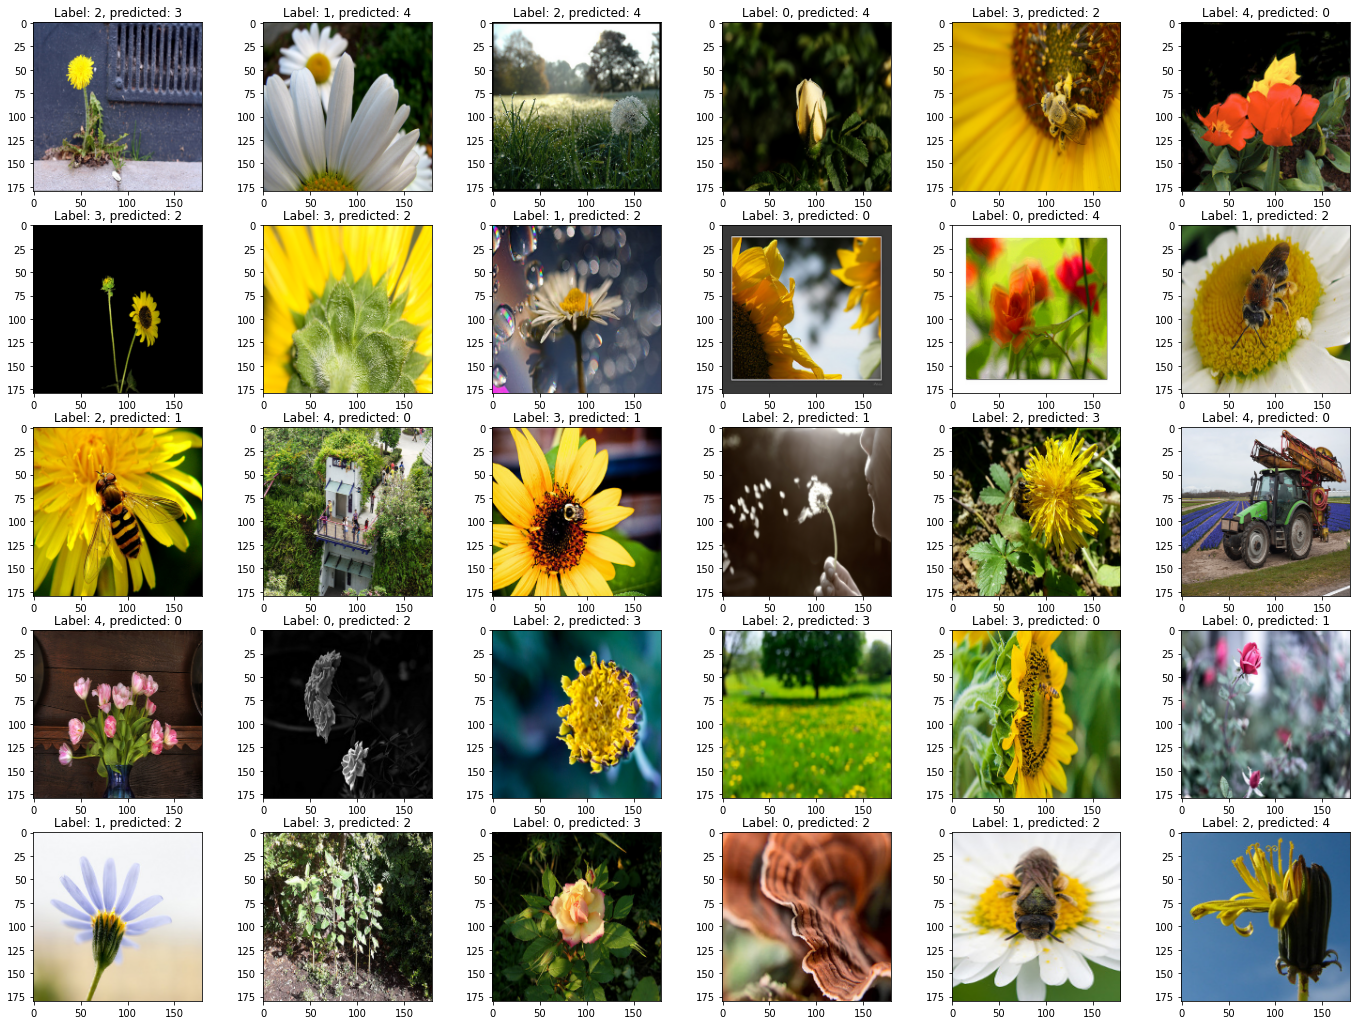

In [19]:
Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    aux = X_test[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()